In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import networkx as nx
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as en
import warnings
from dtreeviz.trees import dtreeviz
import graphviz
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

iic_burden.keys()

sns.set(font_scale=4,style='whitegrid')

def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in (range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['D'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        

df_pkpd = pd.read_csv('PD_Parameters_result.csv',index_col=0)
df_pkpd = df_pkpd.fillna(df_pkpd.mean())

df_coarsen = setup_coarsen_data(iic_burden,window = 6,summarize='max')
# df_pkpd = pd.read_csv('../aim1/step6_simulator/results_iic_burden_smooth/params_mean_CNNIIC_iic_burden_smooth_cauchy_expit_lognormal_drugoutside_ARMA2,6_iter1000.csv',
#                      index_col=0, header=0)
# df_pkpd = df_pkpd[['alpha0', 'alpha[1]','alpha[2]', 'b[lacosamide]', 'b[levetiracetam]',
#                    'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 'b[propofol]','b[valproate]']].fillna(0)
df_coarsen_1 = df_coarsen[iic_burden['Cname']+['mRS', 'E'
                                               ,'lacosamide', 'levetiracetam', 'midazolam', 
                                               'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

df_coarsen_1 = df_coarsen_1.join(df_pkpd,how='inner')
continuous = ['Age','iGCS-Total','iGCS = T?','Worst GCS in 1st 24h','Worst GCS intub','APACHE II 1st 24h',
              'SBP highest (1st 24h)','SBP lowest (1st 24h)','DBP highest (1st 24h)','DBP lowest (1st 24h)',
              'HR highest (1std 24h)','HR lowest (1st 24h)','premorbid MRS']
discrete = set(iic_burden['Cname']).difference(continuous)

df_coarsen_1['Y'] = (df_coarsen_1['mRS'] > 3).astype(float)

n_thresholds = 5
thresholds = [0,0.25,0.5,0.75,1]#list(np.linspace(0,1,num=n_thresholds))
gain = thresholds[1]-thresholds[0]
iic_level = df_coarsen_1['E']>2
for threshold in thresholds:
    iic_level = iic_level + gain*(df_coarsen_1['E']>threshold).astype(int)
    
iic_level = iic_level - (gain/2) * ((iic_level - (gain/2)) > 0)
drug_level = ( (df_coarsen_1['levetiracetam'] > 20) + 
              (df_coarsen_1['propofol']>1) + 
              (df_coarsen_1['midazolam']>0) +
              (df_coarsen_1['lacosamide']>0) +
              (df_coarsen_1['pentobarbital']>0) +
              (df_coarsen_1['phenobarbital']>0) +
              (df_coarsen_1['valproate']>0) ).astype(int)

df_coarsen_1['iic'] = np.round(iic_level,2).astype(str)
df_coarsen_1['drug'] = drug_level
df_coarsen_1['T'] = '('+df_coarsen_1['iic'].astype(str) +', '+df_coarsen_1['drug'].astype(str)+')'

df_race = pd.read_csv('covariates-full.csv',index_col=0)[['Race']]
df_race = df_race.loc[list(df_coarsen_1.index)]
df_race = pd.get_dummies(df_race)[['Race_Asian', 'Race_Black or African American', 'Race_White or Caucasian']]

df_coarsen_1 = df_coarsen_1.join(df_race,how='inner')

df_coarsen_1.to_csv('max_df_coarsen.csv')

In [81]:
iic_burden['Cname']

['Gender',
 'Age',
 'Marrital',
 'iGCS-Total',
 'iGCS = T?',
 'Worst GCS in 1st 24h',
 'Worst GCS intub',
 'APACHE II 1st 24h',
 'SBP highest (1st 24h)',
 'SBP lowest (1st 24h)',
 'DBP highest (1st 24h)',
 'DBP lowest (1st 24h)',
 'HR highest (1std 24h)',
 'HR lowest (1st 24h)',
 'Surgery',
 'Hx CVA',
 'Hx HTN',
 'Hx Sz',
 'Hx brain surgery',
 'Hx CKD',
 'Hx CAD/MI',
 'Hx CHF',
 'Hx DM',
 'Hx HLD',
 'Hx PUD',
 'Hx liver failure',
 'Hx smoking',
 'Hx alcohol',
 'Hx substance abuse',
 'Hx cancer',
 'Hx CNS cancer',
 'Hx PVD',
 'Hx dementia',
 'Hx COPD/Asthma',
 'Hx leukemia/lymphoma',
 'Hx AIDs',
 'Hx CTD',
 'premorbid MRS',
 'OSH time 1st AED',
 'CA (PEA)',
 'Sz at presentation',
 'EEG day1 MV',
 'EEG day1 GCS',
 'EEG day1 sysBP',
 'acute SDH',
 'Sepsis/Shock',
 'NeuroDx:IschStroke',
 'NeuroDx:HemStroke',
 'NeuroDx:SAH',
 'NeuroDx:SDH',
 'NeuroDx:SDH+TBI(SAH)',
 'NeuroDx:TBI(SAH)',
 'NeuroDx:Sz/SE',
 'NeuroDx:Brain tumor',
 'NeuroDx:CNS infection',
 'NeuroDx:HIE/ABI',
 'NeuroDx:TME',
 '

In [4]:
df_coarsen_1.groupby(by='T').count().mean(axis=1)

df_coarsen_1.groupby(by='T').mean()

df_coarsen_1.groupby(by='Y').mean()[['Race_Asian', 'Race_Black or African American', 'Race_White or Caucasian']] *100
(df_coarsen_1.groupby(by='iic').sum()[['Race_Asian', 'Race_Black or African American', 'Race_White or Caucasian']] ).iloc[1:].rename({'0.12': '[0.0,0.25)', 
                                                                                                                                           '0.38': '[0.25,0.50)', 
                                                                                                                                           '0.62': '[0.50,0.75)', 
                                                                                                                                           '0.88': '[0.75,1.00]'}, axis='index')

,Race_Asian,Race_Black or African American,Race_White or Caucasian
iic,,,
"[0.0,0.25)",7.0,21.0,207.0
"[0.25,0.50)",5.0,4.0,101.0
"[0.50,0.75)",2.0,11.0,77.0
"[0.75,1.00]",19.0,33.0,341.0


# Effect of IIC Burden on Outcome

## Controlling for age

In [28]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[['Age','Y','T']]
discrete = []
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

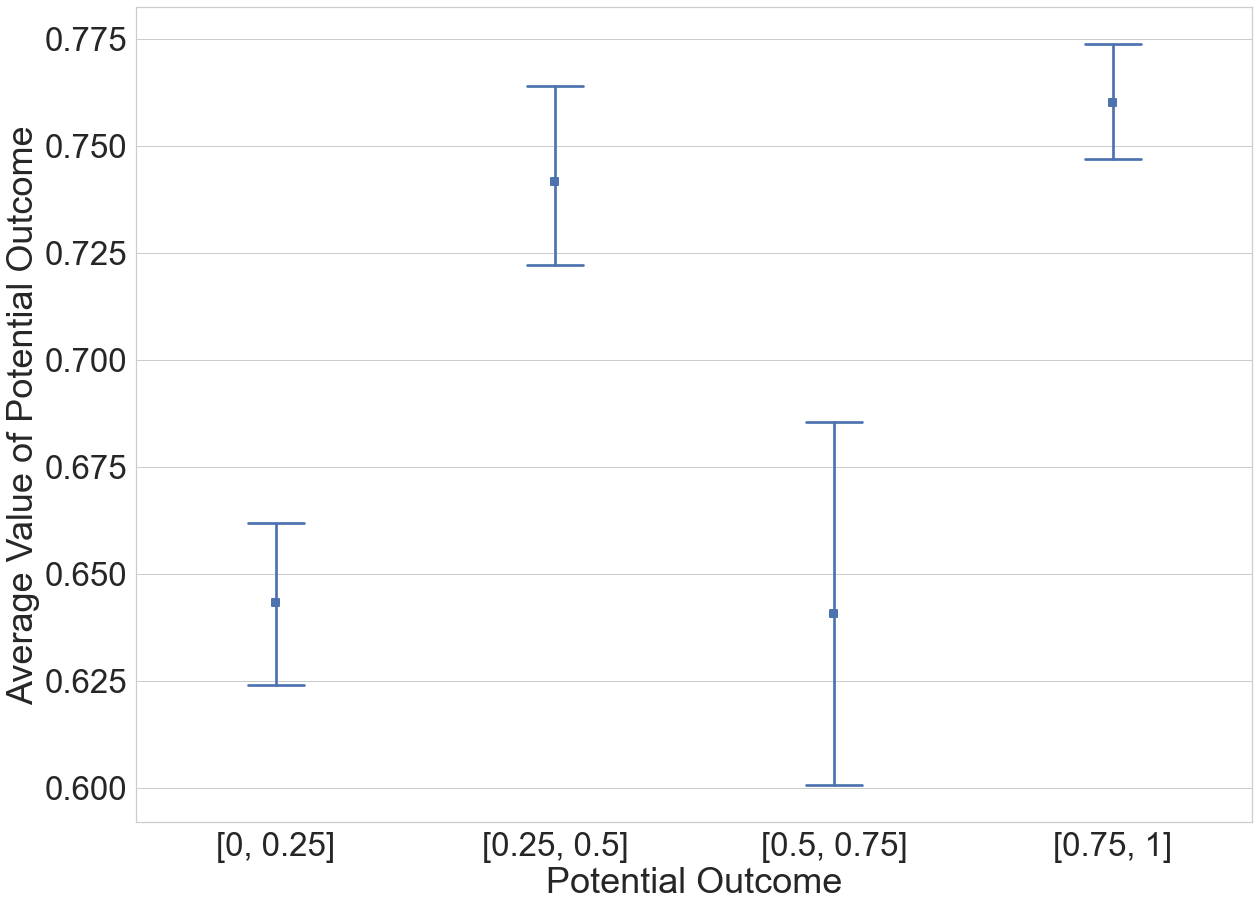

In [29]:
out_age = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out_age.to_csv('new_max_age.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
apo_0_age = out_age[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
apo_1_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
diam_0_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
diam_1_age = out_age[columns]

apo_tight_0_age = pd.DataFrame(apo_0_age.values*(diam_0_age<10).astype(int).replace(0, np.nan).values,
                         index=apo_0_age.index,columns=apo_0_age.columns)
apo_tight_0_age.mean(axis=0)

apo_tight_1_age = pd.DataFrame(apo_1_age.values*(diam_1_age<10).astype(int).replace(0, np.nan).values,
                         index=apo_1_age.index,columns=apo_1_age.columns)
apo_tight_1_age.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_age.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], markersize=520)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_max_age.png')

In [30]:
apo_tight_0_age.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_max_age.csv')

## Controlling for All Preadmission Covariates

In [88]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[iic_burden['Cname']+['Race_Asian', 'Race_Black or African American', 'Race_White or Caucasian']+['Y','T']]
discrete = list(set(iic_burden['Cname']).difference(continuous))

m_c = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

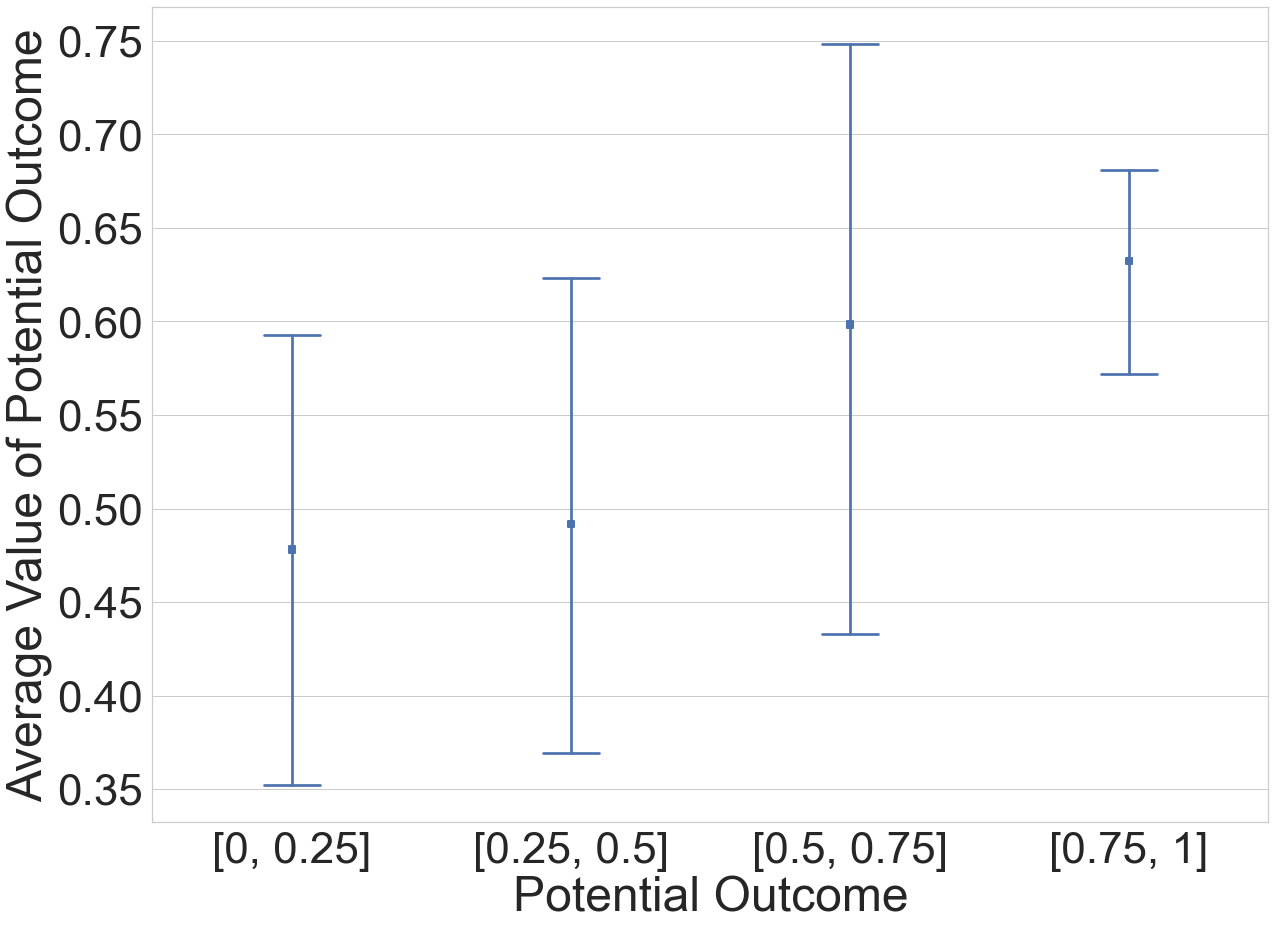

In [89]:
out_c = m_c.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out_c.to_csv('new_max_c.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c = out_c[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c = out_c[columns]

apo_tight_0_c = pd.DataFrame(apo_0_c.values*(diam_0_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_0_c.index,columns=apo_0_c.columns)
apo_tight_0_c.mean(axis=0)

apo_tight_1_c = pd.DataFrame(apo_1_c.values*(diam_1_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_1_c.index,columns=apo_0_c.columns)
apo_tight_1_c.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], markersize=520)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_max_c.png')

In [90]:
apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_max_c.csv')

# Controlling for all pre-admission covariates and PKPD parameters

In [67]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[iic_burden['Cname']+['Race_Asian', 'Race_Black or African American', 'Race_White or Caucasian']+list(df_pkpd.columns)+['Y','T']]
discrete = list(set(iic_burden['Cname']).difference(continuous))
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=3,
                k_est=5,
                discrete = discrete,
                C=0.01)

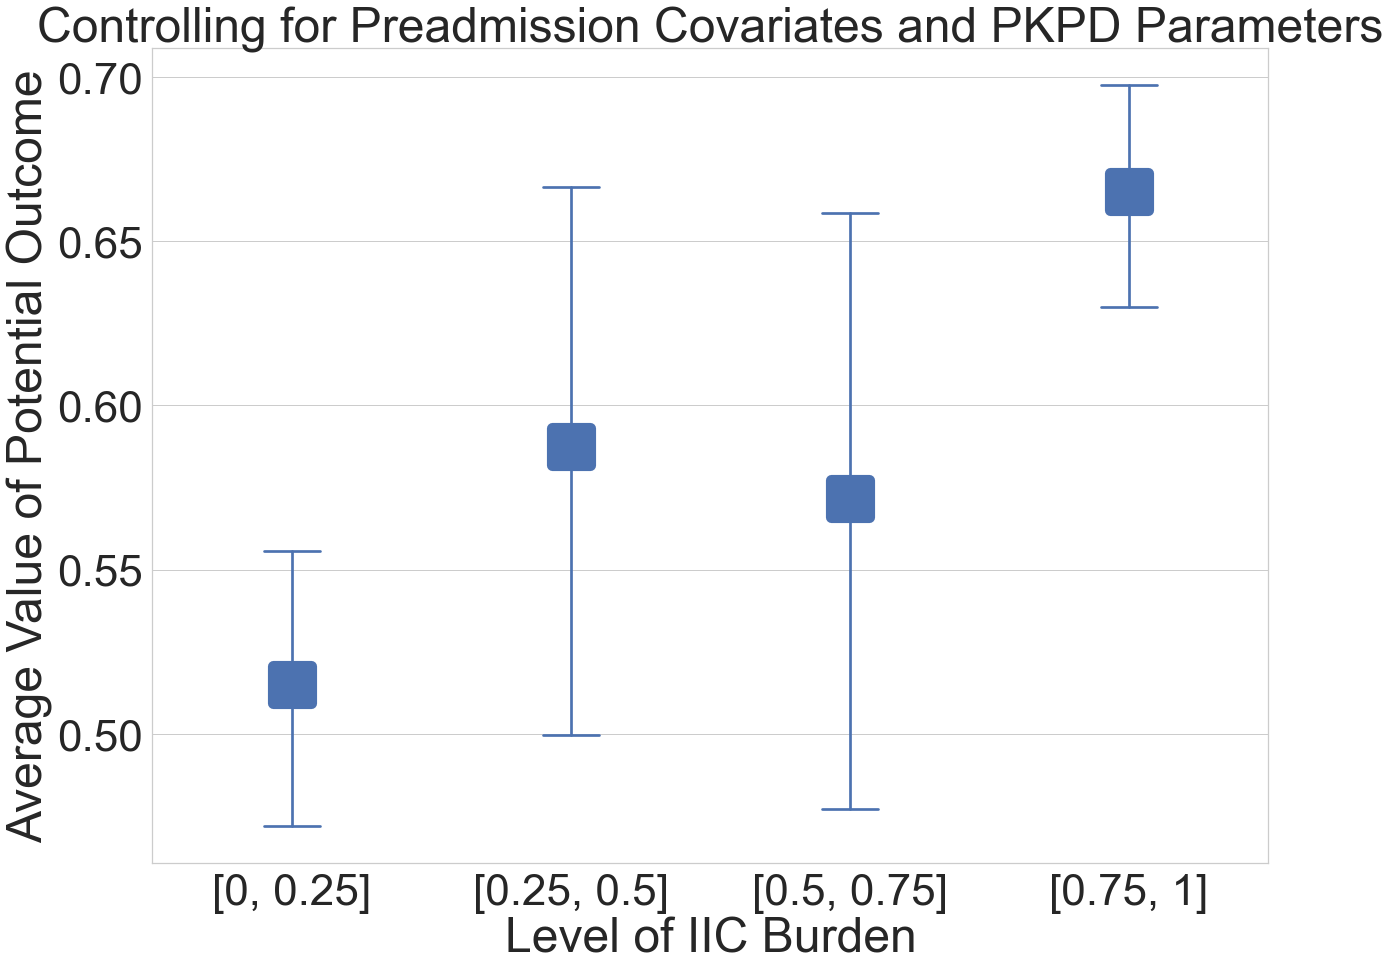

In [68]:
out = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out.to_csv('new_max_c_pkpd.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c_pkpd = out[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c_pkpd = out[columns]

apo_tight_0_c_pkpd = pd.DataFrame(apo_0_c_pkpd.values*(diam_0_c_pkpd<2000).astype(int).replace(0, np.nan).values,
                         index=apo_0_c_pkpd.index,columns=apo_0_c_pkpd.columns)
apo_tight_0_c_pkpd.mean(axis=0)

apo_tight_1_c_pkpd = pd.DataFrame(apo_1_c_pkpd.values*(diam_1_c_pkpd<2000).astype(int).replace(0, np.nan).values,
                         index=apo_1_c_pkpd.index,columns=apo_0_c_pkpd.columns)
apo_tight_1_c_pkpd.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], scale = 5.5)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
plt.xlabel('Level of IIC Burden')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
plt.title('Controlling for Preadmission Covariates and PKPD Parameters')
fig.savefig('new_max_c_pkpd.png')

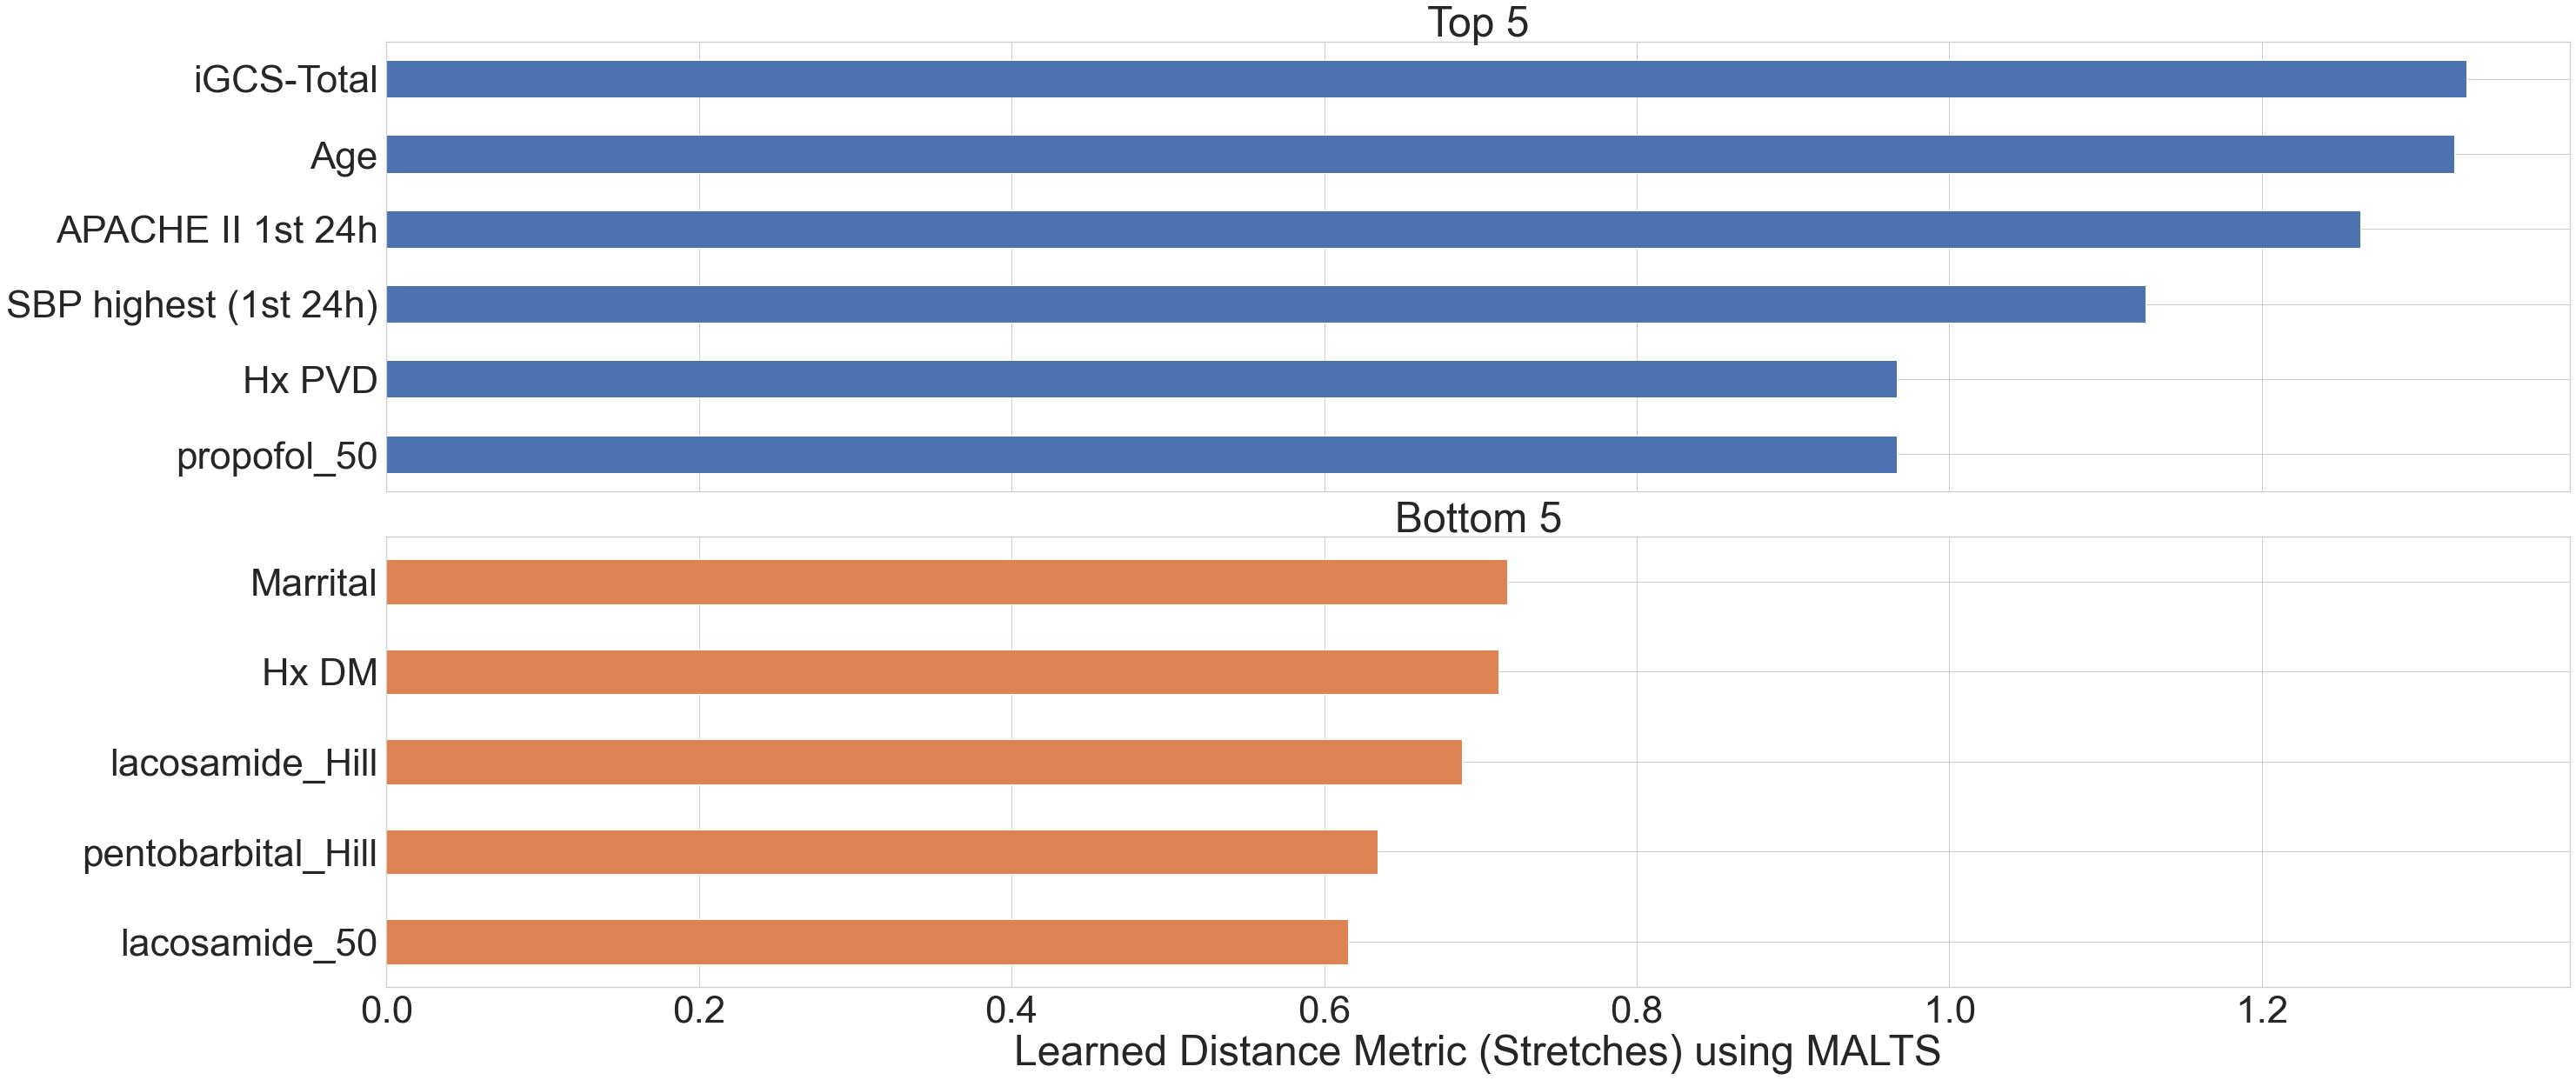

In [9]:
fig,ax = plt.subplots(figsize=(45,20),nrows=2,sharex=True)
# pd.concat(m.M_opt_list).to_csv('M_opt_max.csv')
M_opt = pd.read_csv('M_opt_max.csv',index_col=0)
columns_order = list(M_opt.mean(axis=0).sort_values(ascending=False).index)
columns_to_include_top = ['iGCS-Total','Age','APACHE II 1st 24h','SBP highest (1st 24h)','Hx PVD','propofol_50'][::-1]
columns_to_include_bottom = ['Marrital','Hx DM','lacosamide_Hill','pentobarbital_Hill','lacosamide_50'][::-1]
# pd.concat(m.M_opt_list)[columns_order].plot(kind='box',ax=ax,rot=90,showmeans=True)
# M_opt[columns_to_include].std(axis=0)/2
# plt.ylim(-0.001,1.0)
M_opt[columns_to_include_top].mean(axis=0).plot(kind='barh',ax=ax[0],color='C0')
ax[0].set_title('Top 5')
# ax[0].set_xticks([1,2,3,4,5],['Initial Glasgow Comma Score','Age','APACHE II Score','Systolic Blood Pressure','Peripheral vascular disease','Propofol50'])
M_opt[columns_to_include_bottom].mean(axis=0).plot(kind='barh',ax=ax[1],color='C1')
ax[1].set_title('Bottom 5')
plt.subplots_adjust(wspace=0.005, hspace=0.1)
plt.xlabel('Learned Distance Metric (Stretches) using MALTS')
plt.savefig('max_stretchplot.png')


In [10]:
pd.concat(m.M_opt_list).mean(axis=0).to_csv('MALTS_distmat.csv')

In [101]:
apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_c_pkpd.csv')

In [102]:
out_age= pd.read_csv('new_max_age.csv',index_col=0)
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
apo_0_age = out_age[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
apo_1_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
diam_0_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
diam_1_age = out_age[columns]

apo_tight_0_age = pd.DataFrame(apo_0_age.values*(diam_0_age<10).astype(int).replace(0, np.nan).values,
                         index=apo_0_age.index,columns=apo_0_age.columns)



out_c = pd.read_csv('new_max_c.csv',index_col=0)
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c = out_c[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c = out_c[columns]

apo_tight_0_c = pd.DataFrame(apo_0_c.values*(diam_0_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_0_c.index,columns=apo_0_c.columns)



out = pd.read_csv('new_max_c_pkpd.csv',index_col=0)
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c_pkpd = out[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c_pkpd = out[columns]

apo_tight_0_c_pkpd = pd.DataFrame(apo_0_c_pkpd.values*(diam_0_c_pkpd<2000).astype(int).replace(0, np.nan).values,
                         index=apo_0_c_pkpd.index,columns=apo_0_c_pkpd.columns)

In [103]:
apo_tight_0_age = pd.read_csv('average_te_max_age.csv',index_col=0)
apo_tight_0_c = pd.read_csv('average_te_max_c.csv',index_col=0)
apo_tight_0_c_pkpd = pd.read_csv('average_te_c_pkpd.csv',index_col=0)

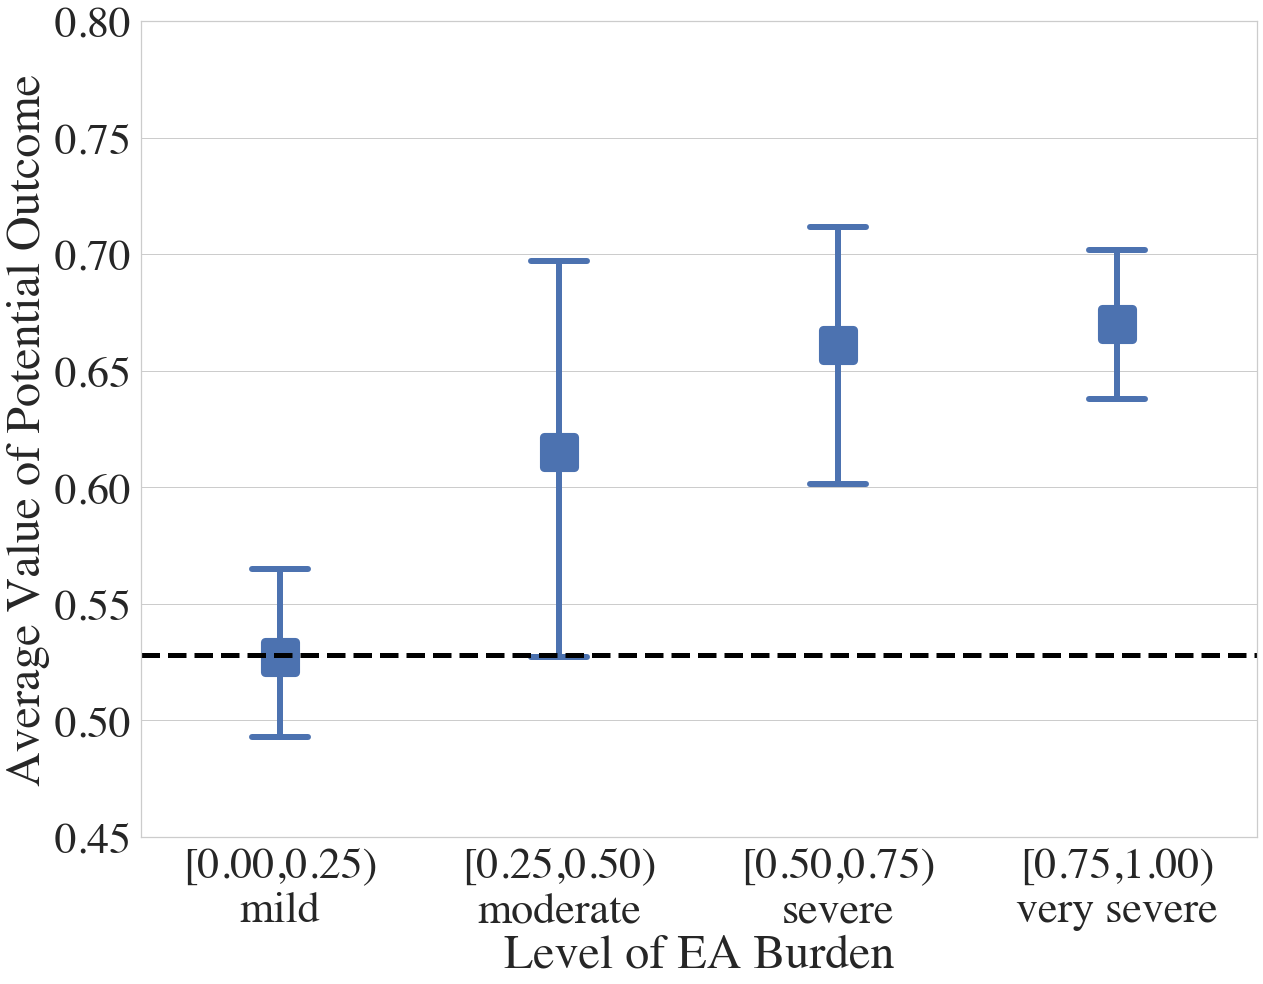

In [117]:
sns.set(font_scale=4,style='whitegrid')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)

fig,ax = plt.subplots(figsize=(20,15))
control = ['Preadmission Covariate\n and PKPD Parameters']#,'Preadmission Covariate','Age']
df_apo = [apo_tight_0_c_pkpd]#,apo_tight_0_c,apo_tight_0_age]
df_plot = pd.DataFrame()
for i in range(1):
    df_plot_ = df_apo[i]
    df_plot_['Controlling For'] = [control[i] for k in range(df_plot_.shape[0])]
    df_plot = df_plot.append(df_plot_)

sns.pointplot(data=df_plot,
             x='index',y='Average Potential Outcome',
             hue='Controlling For',ax=ax,join=False,
             capsize=.2,markers=['s','o','v'],dodge=0.25,scale = 4.5,errwidth=6,ci=90)
# sns.lineplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_0.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
# plt.legend(['Preadmission Covariate\n and PKPD Parameters','Preadmission Covariate','Age'],title="Controlling for")
plt.axhline(0.528,c='black',ls='--',lw=5)
plt.xlabel('Level of EA Burden')
plt.ylabel('Average Value of Potential Outcome')
plt.ylim((0.45,0.8))
level_eng = ['mild','moderate','severe','very severe']
plt.xticks(np.arange(len(thresholds)-1),['[%.2f,%.2f)\n%s'%(thresholds[i-1],thresholds[i],level_eng[i-1]) for i in range(1,len(thresholds)) ] )
plt.legend([],[], frameon=False)
fig.savefig('c_pkpd_max.png')

# Comparing to Prediction Model

In [106]:
df_logistic = df_coarsen_1[iic_burden['Cname']+['Y','E','drug']]

In [108]:
model = lm.LogisticRegressionCV().fit( df_coarsen_1[iic_burden['Cname']+['E','drug']],  df_coarsen_1[['Y']] )

In [ ]:
df_logistic 

In [107]:
df_logistic

,Gender,Age,Marrital,iGCS-Total,iGCS = T?,Worst GCS in 1st 24h,Worst GCS intub,APACHE II 1st 24h,SBP highest (1st 24h),SBP lowest (1st 24h),...,PrimDx:LiverDisorder,PrimDx:GI,PrimDx:GU,PrimDx:EndoEmegy,PrimDx:NonHeadTrauma,PrimDx:Malignancy,PrimDx:Hem,Y,E,drug
sid3,1.0,45.91,1.0,8.0,0.0,8.0,0.0,15.0,148.0,139.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1
sid4,1.0,53.99,1.0,4.0,0.0,3.0,1.0,29.0,170.0,50.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.967960,1
sid5,1.0,23.08,0.0,6.0,1.0,3.0,1.0,22.0,126.0,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102834,1
sid7,1.0,32.11,1.0,3.0,1.0,3.0,1.0,16.0,133.0,112.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1
sid8,0.0,67.24,0.0,12.0,0.0,11.0,0.0,14.0,200.0,147.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.908257,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sid1986,0.0,58.96,1.0,14.0,0.0,14.0,0.0,6.0,135.0,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1
sid1989,1.0,61.04,1.0,15.0,0.0,15.0,0.0,3.0,148.0,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.442361,1
sid1990,1.0,24.09,0.0,15.0,0.0,15.0,0.0,0.0,131.0,115.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1
sid1991,0.0,74.84,1.0,15.0,0.0,10.0,0.0,11.0,163.0,127.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.943889,1


In [146]:
max_logit

,Value,IIC_Burden,Control
1,0.686275,Mild,Naive Difference of Means
2,0.700000,Moderate,Naive Difference of Means
3,0.437500,Severe,Naive Difference of Means
4,0.666667,Very Severe,Naive Difference of Means
5,0.666667,Mild,Naive Difference of Means
...,...,...,...
176,0.710361,Very Severe,Regression Approach
177,0.730392,Mild,Regression Approach
178,0.680920,Moderate,Regression Approach
179,0.645647,Severe,Regression Approach


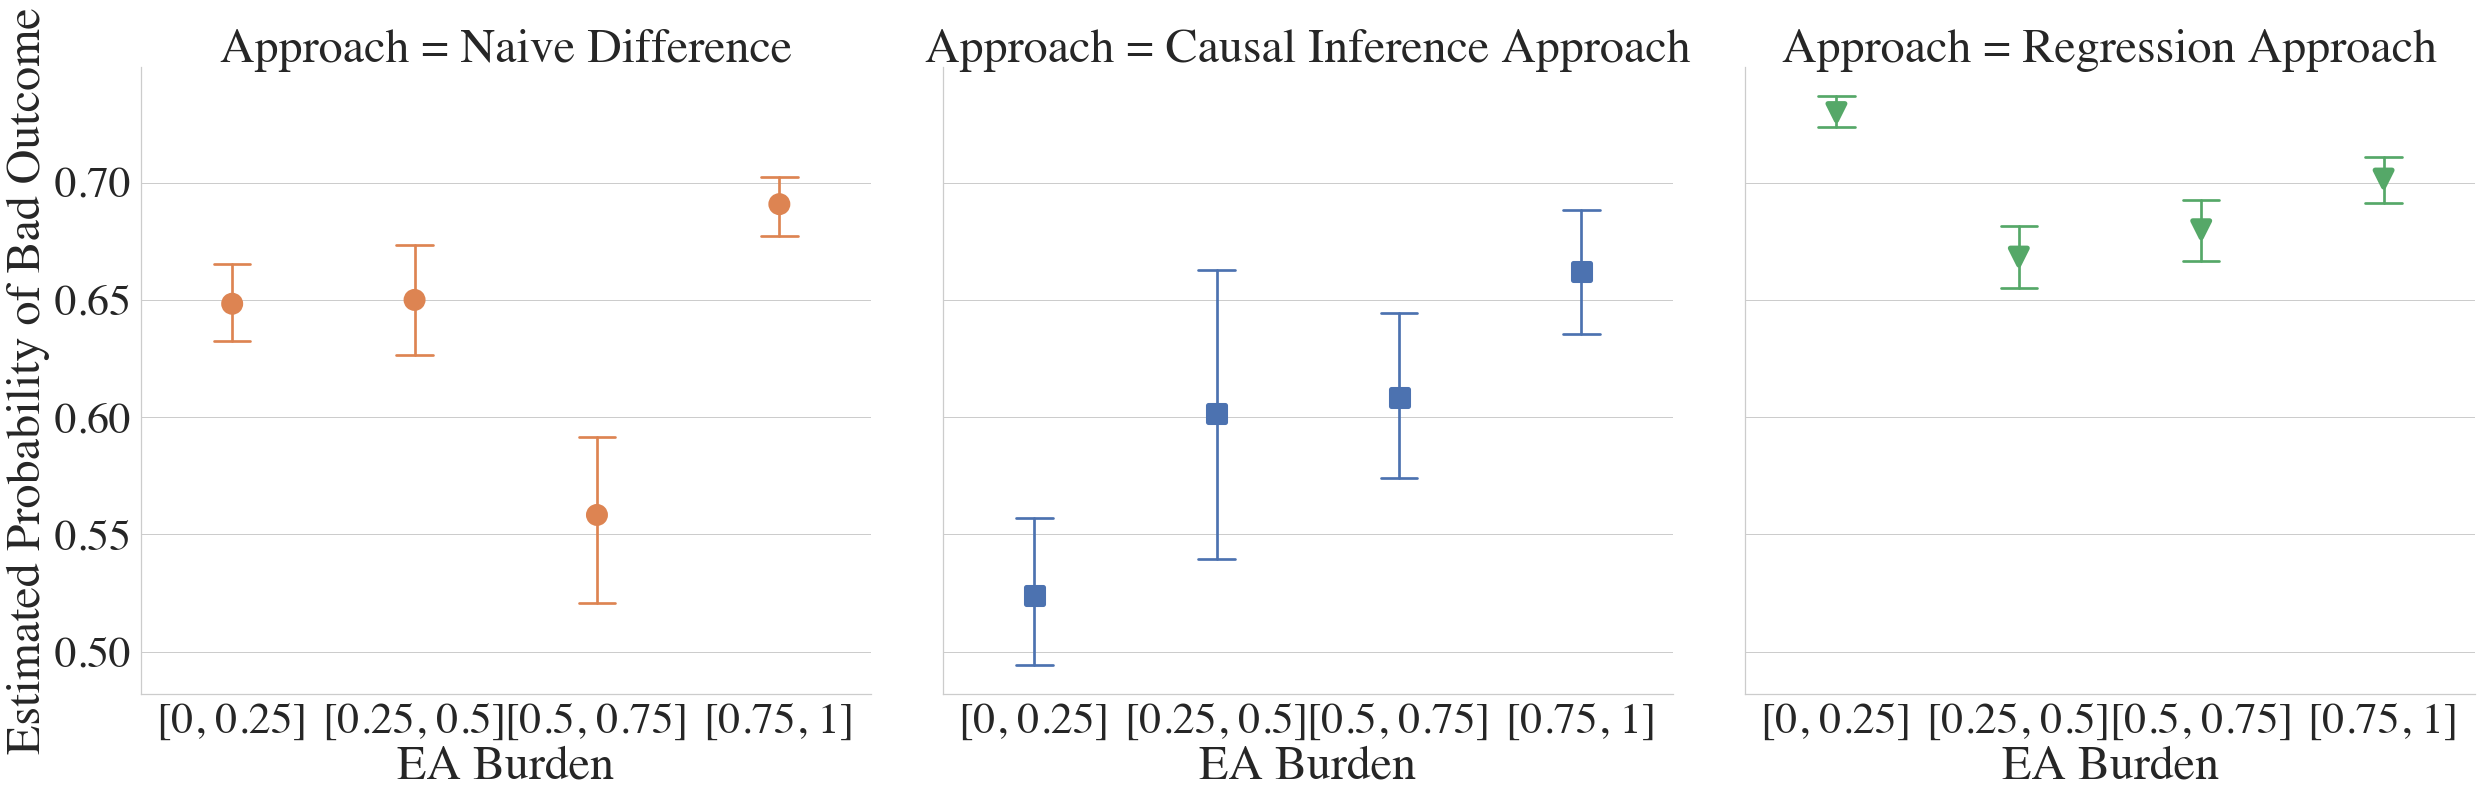

In [187]:
sns.set(font_scale=4,style='whitegrid')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)
max_logit = pd.read_csv('max_logistics_ates.csv',index_col=0).replace({'No Control':'Naive Difference of Means','Logistic Regression':'Prediction Modeling (Logistic Regression)','Controlling for Everything':'Causal Estimation (MALTS)'})
mean_log = pd.read_csv('mean_logistics_ates.csv',index_col=0).replace({'No Control':'Naive Difference of Means','Logistic Regression':'Prediction Modeling (Logistic Regression)','Controlling for Everything':'Causal Estimation (MALTS)'})

# fig,ax = plt.subplots(figsize=(20,15))
g = sns.FacetGrid(max_logit, col="Approach", hue="Approach", 
                  hue_order=['Causal Inference Approach','Naive Difference','Regression Approach'], 
                  hue_kws={'markers' : ['s','o','v']},
                  sharey=True,sharex=True,height=12,aspect=1)
g.map(sns.pointplot,'EA Burden','Estimated Probability of Bad Outcome',ax=ax,join=False,capsize=.2,dodge=0.25,scale = 2.5,ci=90)
#       (data=max_logit,x='IIC_Burden',y='Value',
#               hue_order=['Causal Inference Approach','Naive Difference of Means','Regression Approach'],
#               ax=ax,join=False,
#              capsize=.2,markers=['s','o','v'],dodge=0.25,scale = 2.5,ci)

plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
# plt.legend(title=None)
plt.savefig('max_reg.png')

# Matched Group Analysis

In [77]:
MG = m.MG_matrix
MG_b = (MG>7).astype(int) 
MG_b = MG_b.loc[MG_b.sum(axis=1)>0]
MG_b = MG_b[list(MG_b.index)]
MG.to_csv('matched_group_matrix.csv')

In [78]:

tight_mg_idx = list(diam_0_c_pkpd.max(axis=1).sort_values().index[:6])
for idx in tight_mg_idx:
    MG_i = MG_b.loc[idx]
    df_malts_data.loc[MG_i.loc[MG_i>0].index].to_csv('mg_%s.csv'%(idx))

In [79]:
G = nx.from_pandas_adjacency(MG_b)

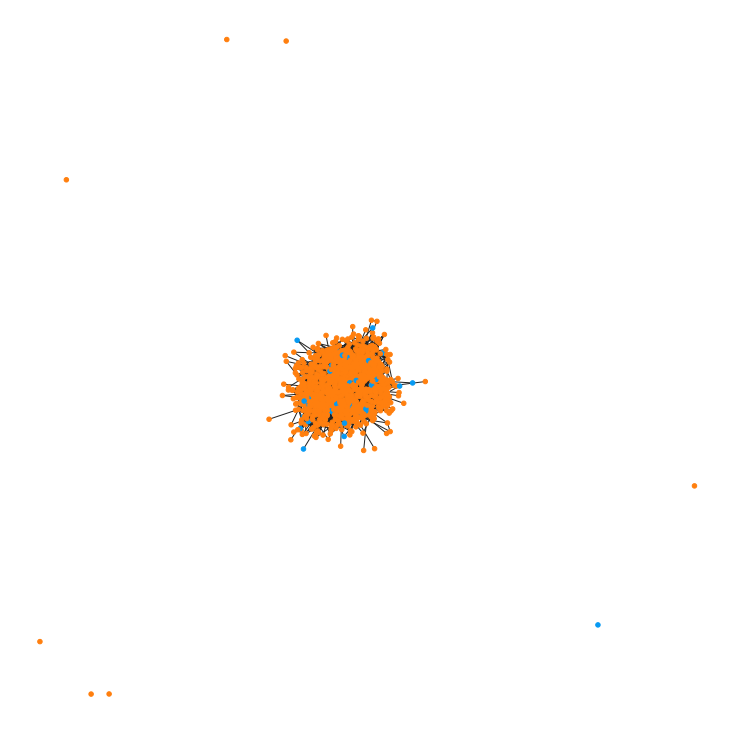

In [80]:
fig = plt.figure(figsize=(10,10))
node_color = [ '#ff7f0e' if df_malts_data.loc[i,'Hx PVD']==0 else '#069af3' for i in (MG_b.index) ]
nx.draw(G,node_size=20,node_color=node_color,edge_color='#222222')

# Heterogeneous Effect

In [61]:
out = pd.read_csv('new_max_c_pkpd.csv',index_col=0)

In [62]:
y_u = out[[i for i in out.columns if 'Y((0.88, 1))' in i]].mean(axis=1)
y_l = out[[i for i in out.columns if 'Y((0.12, 1))' in i]].mean(axis=1)
te = y_u-y_l

In [63]:
# cols = iic_burden['Cname']
hetero_te_m = {}
cols = ['NeuroDx:IschStroke', 
        'NeuroDx:HemStroke',
         'NeuroDx:Brain tumor',
         'NeuroDx:CNS infection',
         'NeuroDx:HIE/ABI',
         'NeuroDx:TME',
         'NeuroDx:Degenerative',
         'NeuroDx:Spells']
for col in cols:
    hetero_te_m[col] = tree.DecisionTreeRegressor(max_depth=4,max_leaf_nodes=8,min_samples_leaf=10).fit(df_coarsen_1[[col]],100*(y_u - y_l)/y_l)

hetero_te_m['all'] = tree.DecisionTreeRegressor(max_depth=2,max_leaf_nodes=8,min_samples_leaf=50).fit(df_coarsen_1[cols],100*(y_u - y_l)/y_l)

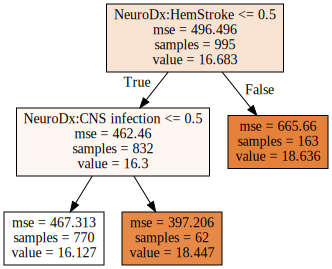

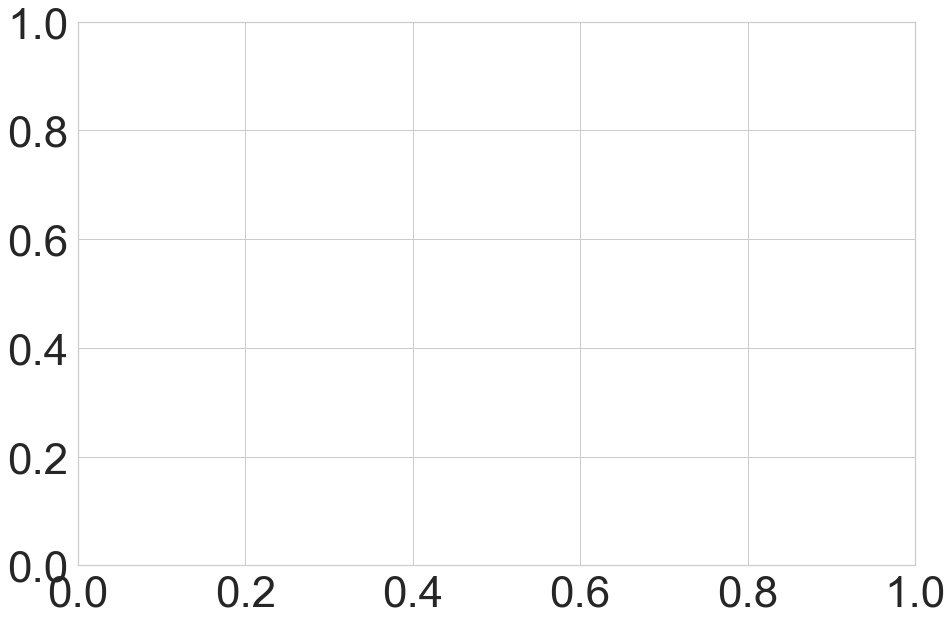

In [64]:
fig,ax = plt.subplots(figsize=(15,10))
dot_data = tree.export_graphviz(hetero_te_m['all'],feature_names=cols,filled=True)
graphviz.Source(dot_data, format="png") 
# fig.savefig('hetero_tree_%s.png'%('all'))

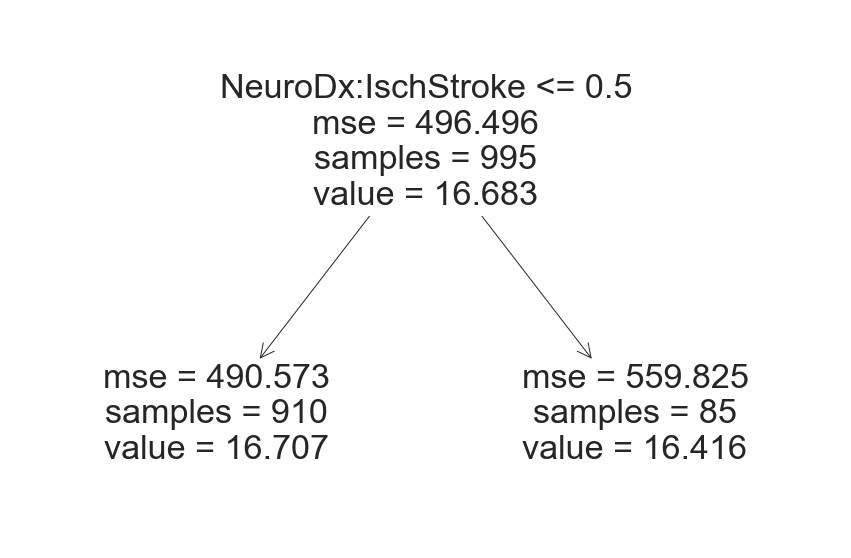

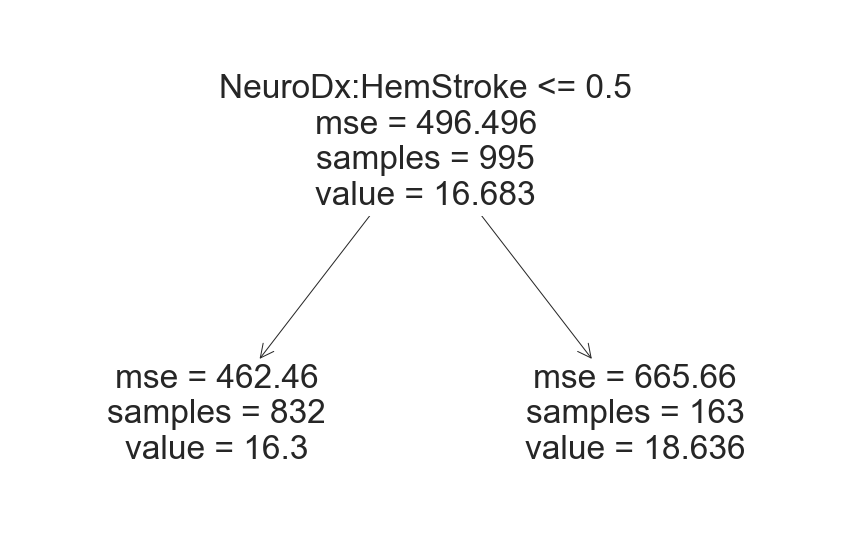

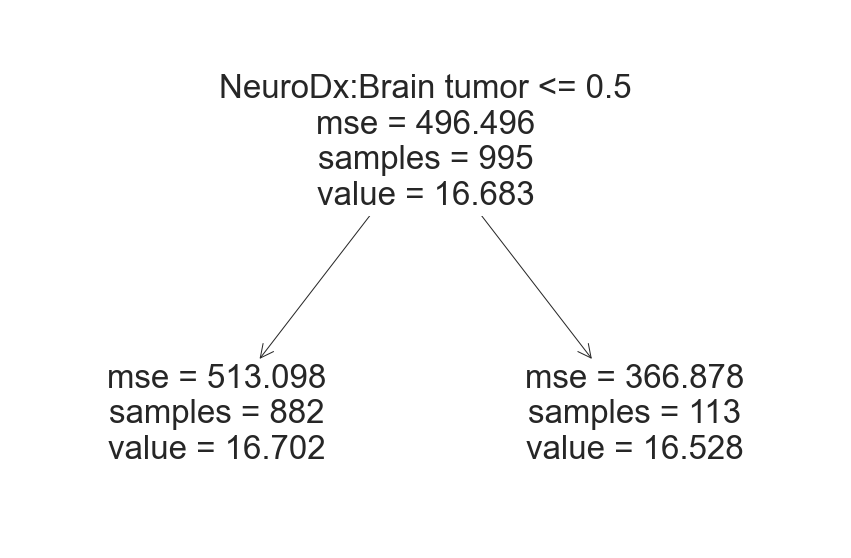

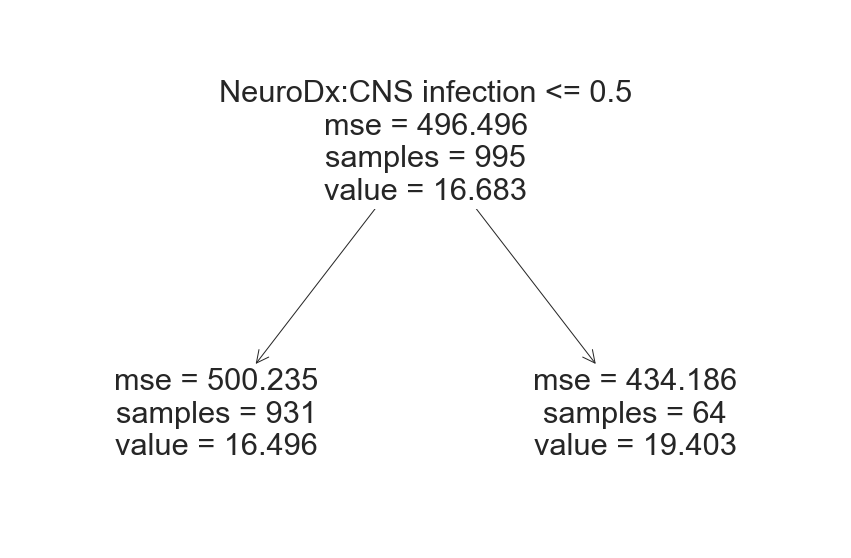

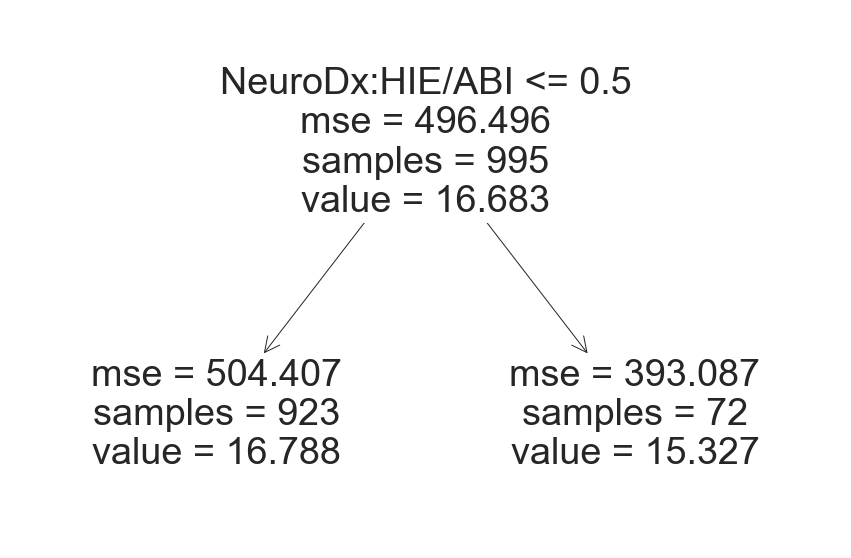

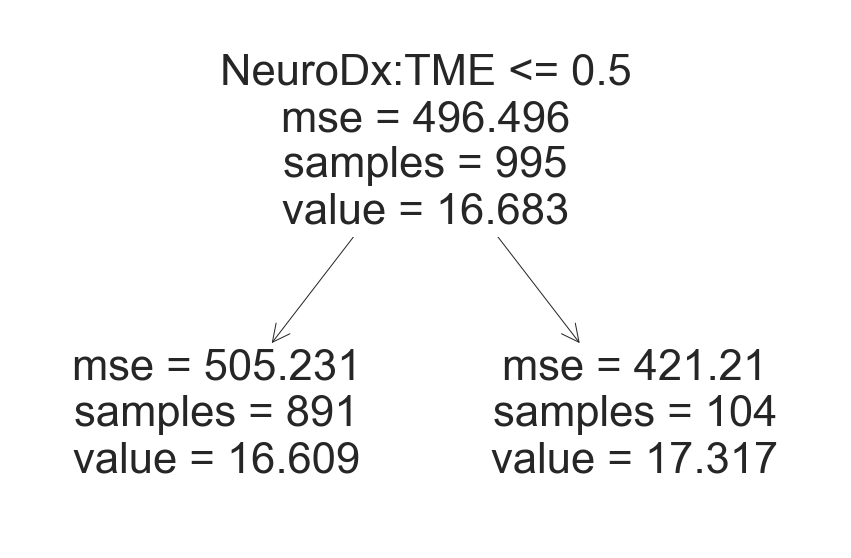

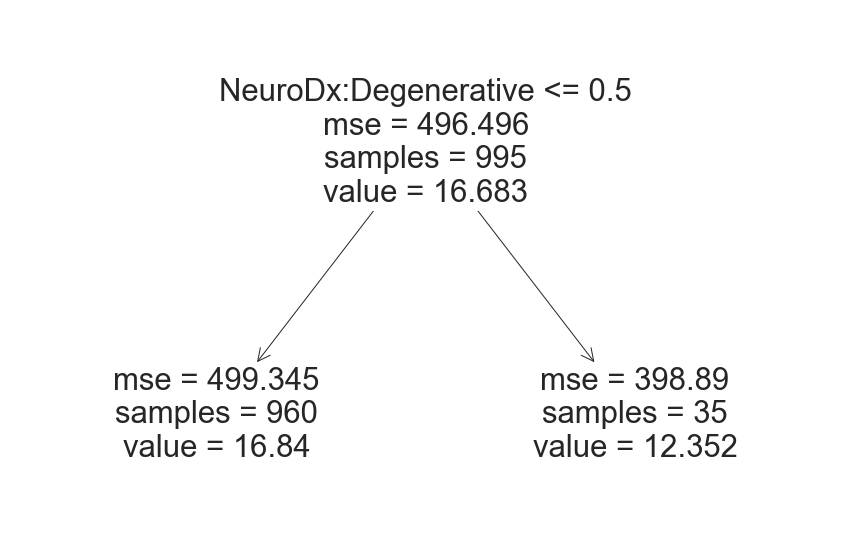

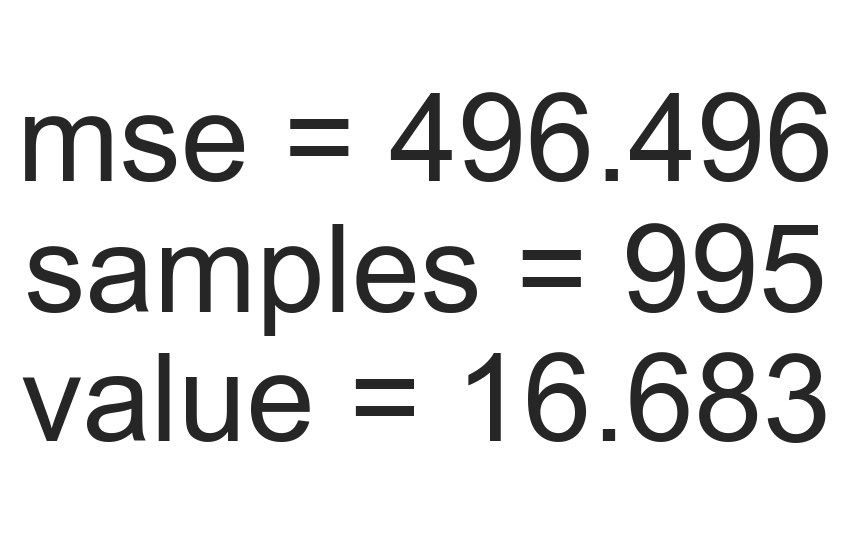

In [65]:
for col in cols:
    fig,ax = plt.subplots(figsize=(15,10))
    tree.plot_tree(hetero_te_m[col],feature_names=[col],filled=False)
    fig.savefig('hetero_tree_%s.png'%(col.replace('/','_').replace(':','_')))

In [122]:
df_apo_pkpd_c = cate_df[list(filter( lambda x: 'Y(' in x, cate_df.columns ))].T.reset_index().groupby(by='index').mean().T
df_apo_pkpd_c.to_csv('potential_outcome_pkpd_c.csv')

<AxesSubplot:ylabel='Density'>

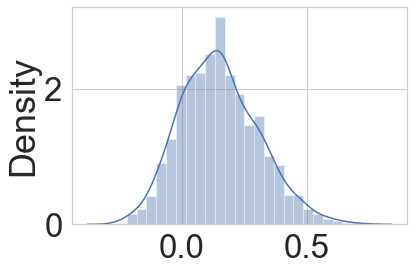

In [123]:
te = df_apo_pkpd_c['Y((0.88, 0))'] - df_apo_pkpd_c['Y((0.12, 0))'] 
sns.distplot(te)

In [124]:
# hetero_te_m = {}
# cols = ['NeuroDx:IschStroke', 
#         'NeuroDx:HemStroke',
#          'NeuroDx:SAH',
#          'NeuroDx:SDH',
#          'NeuroDx:SDH+TBI(SAH)',
#          'NeuroDx:TBI(SAH)',
#          'NeuroDx:Sz/SE',
#          'NeuroDx:Brain tumor',
#          'NeuroDx:CNS infection',
#          'NeuroDx:HIE/ABI',
#          'NeuroDx:TME',
#          'NeuroDx:Psyc',
#          'NeuroDx:Degenerative',
#          'NeuroDx:Spells',
#          'PrimDx:Resp',
#          'PrimDx:Cardio',
#          'PrimDx:RenalFailure',
#          'PrimDx:LiverDisorder',
#          'PrimDx:GI',
#          'PrimDx:GU',
#          'PrimDx:EndoEmegy',
#          'PrimDx:NonHeadTrauma',
#          'PrimDx:Malignancy',
#          'PrimDx:Hem']
hetero_te_m = tree.DecisionTreeRegressor(max_depth=4,max_leaf_nodes=8,min_samples_leaf=10).fit(df_malts_data[cols],te)

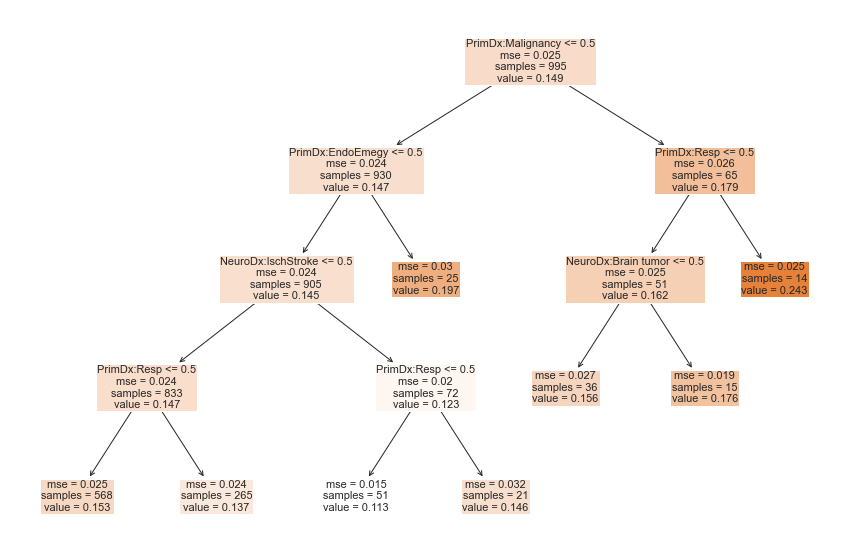

In [125]:
fig,ax = plt.subplots(figsize=(15,10))
tree.plot_tree(hetero_te_m,feature_names=cols,filled=True)
fig.savefig('hetero_tree.png')

In [ ]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_dict = df_dict_dict[type_summary]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 0) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
                                                                       & (m_dict[threshold].CATE_df['avg.Diameter'] <= 3*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

In [ ]:
for type_summary in df_m_atec_dict.keys():
    df_m_atec = df_m_atec_dict[type_summary]
    df_m_atec.to_csv('df_m_atec_'+type_summary+'_c_pkpd.csv')

In [ ]:
for type_summary in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(16,14))
    df_m_atec_dict[type_summary].T.plot(kind='box',showmeans=True,
                                        ax=ax,
                                        patch_artist=True,
#                                         meanline=True,
                                        capprops={'alpha':0.6,'lw':5},
                                        whiskerprops = {'alpha':0.6,'lw':5},
                                        boxprops={'alpha':0.6,'lw':5},
                                        medianprops={'lw':4,'color':'black','ls':'--'},
                                        meanprops={'markersize':15,'markerfacecolor':'black'})
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('$\\mathbb{E}(Y(E_{%s} \\in threshold, \\bar{0}) - Y(E_{%s} \\in [0.0,0.1],\\bar{0}))$'%(type_summary,type_summary))
    plt.xlabel('$threshold$')
    plt.title('%s'%(type_summary))
    fig.savefig(type_summary+'_c_pkpd.png')

In [ ]:
df_m_atec_dict['max']

In [ ]:
for type_summary in ['max','mean']:
    fig,ax = plt.subplots(figsize=(20,16))
    df_m_atec = df_m_atec_dict[type_summary]
#     for control_var in ['c_pkpd']:
#         df_m_atec =  pd.read_csv('df_m_atec_'+type_summary+'_'+control_var+'.csv').rename(columns={'Unnamed: 0':'index'})
    levels = list(df_m_atec.reset_index()['index'])
    df = pd.DataFrame(df_m_atec.reset_index().drop(columns=['index']).stack(level=0).droplevel(1),columns=['ATE'])
    df['Level'] = df.index
    sns.lineplot(x='Level',y='ATE',data=df,ci='sd')
    plt.xlim((0,2))
#     plt.legend(['Age','All Preadmission Covariates','All Preadmission Covariates \nand PKPD Parameters'],title="Controlling for")
    plt.xticks(np.arange(len(levels)),levels,rotation=90)
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('Estimated Causal Effect')
               # \n$\\mathbb{E}(Y(E_{%s} \\in threshold, \\bar{0}) - Y(E_{%s} \\in [0.0,0.1],\\bar{0}))$'%(type_summary,type_summary)
    plt.xlabel('IIC Burden')
    plt.title('%s'%(type_summary))
#     fig.savefig(type_summary+'_line.png')

In [ ]:
pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum()

In [ ]:
df_means

# Heterogeneous Effects

In [ ]:
type_summary = 'max'
threshold = 0.8
df_analysis = df_dict_dict[type_summary][threshold].join(m_dict_dict[type_summary][threshold].CATE_df['avg.CATE']).loc[(df_dict_dict[type_summary][threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict_dict[type_summary][threshold]['propofol']<=1) 
                                                                       & (df_dict_dict[type_summary][threshold]['midazolam']<=0.1)
                                                                       & (df_dict_dict[type_summary][threshold]['lacosamide']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['pentobarbital']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['phenobarbital']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['valproate']<=0)
                                                                       & (m_dict_dict[type_summary][threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])]

In [ ]:
import sklearn.tree as tree

In [ ]:
ex_model = tree.DecisionTreeRegressor(max_leaf_nodes=8,min_samples_leaf=15,min_impurity_decrease=0.0001).fit(df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']),
                                                            df_analysis['avg.CATE'])
# df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]','premorbid MRS before admission  (modified ranking scale),before admission'])

In [ ]:

fig,ax = plt.shetero_te_mlots(figsize=(20,15))
tree.plot_tree(ex_model,feature_names=df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).rename(columns={'premorbid MRS before admission  (modified ranking scale),before admission':'preadmission mRS','iMV  (initial (on admission) mechanical ventilation)':'mechanical ventilation'}).columns,filled=True)

In [ ]:
import sklearn.ensemble as en

In [ ]:
ex_model_ada = en.AdaBoostRegressor(n_estimators=1000).fit(df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']),
                                                            df_analysis['avg.CATE'])

In [ ]:
df_analysis['avg.CATE']

In [ ]:
age_range = np.arange(18,80)
dumy_x_0 = np.zeros((len(age_range),df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).shape[1]))
dumy_x_1 = np.ones((len(age_range),df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).shape[1]))
dumy_x_0[:,1] = age_range
dumy_x_1[:,1] = age_range
acc_res_0 = 0
acc_res_1 = 0
counter = 0
for estimator in ex_model_ada.estimators_:
    if estimator.feature_importances_[1]>0:
        acc_res_0 += estimator.predict(dumy_x_0)
        acc_res_1 += estimator.predict(dumy_x_1)
        counter += 1
acc_res_0 = acc_res_0/counter
acc_res_1 = acc_res_1/counter

In [ ]:
sns.regplot(age_range,acc_res_0,order=4,scatter=False)
sns.regplot(age_range,acc_res_1,order=4,scatter=False)

In [ ]:
for type_summary in m_dict_dict.keys():
    for threshold in m_dict_dict[type_summary].keys():
        m_dict_dict[type_summary][threshold].CATE_df.to_csv('CATES_%s_%.0f.csv'%(type_summary,threshold*10))
        m_dict_dict[type_summary][threshold].MG_matrix.to_csv('MG_%s_%.0f.csv'%(type_summary,threshold*10))
        df_dict_dict[type_summary][threshold].to_csv('df_malts_estimation_set_%s_%.0f.csv'%(type_summary,threshold*10))
    df_means_dict[type_summary].to_csv('descriptive_summary_estimation_set_%s.csv'%(type_summary))

In [ ]:
age_range = np.arange(18,80)

In [ ]:
age_range

In [ ]:
df_control_max = df_dict_dict['max'][0.8].loc[df_dict_dict['max'][0.8]['T']==0]

In [ ]:
sns.scatterplot(data=df_control_max,y='Y',x='Age')

In [ ]:
columns = ['20-40','40-60','70+']
index = ['% mRS $\\leq$ 3','% mRS > 3']
mat = np.zeros((2,3))
for i in df_control_max.index:
    age = df_control_max.loc[i,'Age']
    y = df_control_max.loc[i,'Y']
    if age<40:
        mat[int(y),0] += 1
    elif age<60:
        mat[int(y),1] += 1
    elif age>60:
        mat[int(y),2] += 1
mat[:,0] = mat[:,0]*100.0/np.sum(mat[:,0])
mat[:,1] = mat[:,1]*100.0/np.sum(mat[:,1])
mat[:,2] = mat[:,2]*100.0/np.sum(mat[:,2])
df_mat = pd.DataFrame(mat,columns=columns,index=index)

In [ ]:
plt.figure(figsize=(15,6.75))
sns.heatmap(df_mat,annot=True,cmap="RdBu_r")
plt.ylabel('$Y(e \\in [0\%,10\%], d = 0 )$')
plt.xlabel('Age')
plt.savefig('y0_age.png')

In [ ]:
m_dict_dict['max'][0.8].CATE_df.loc[df_dict_dict['max'][0.8]['T']==0]

In [ ]:
type_summary = 'max'
threshold = 0.8
gph = m_dict_dict[type_summary][threshold].MG_matrix

In [ ]:
import networkx

In [ ]:
G_max_8 = networkx.from_pandas_adjacency((gph>24).astype(int))

In [ ]:
fig = plt.figure(figsize=(10,10))
node_color = [ 'red' if df_dict_dict[type_summary][threshold].loc[i,'T']==1 else 'blue' for i in (df_dict_dict[type_summary][threshold].index) ]
networkx.draw(G_max_8,node_size=10,node_color=node_color)

In [ ]:
fig = plt.figure(figsize=(10,8))
node_color = [ '#ff7f0e' if df_dict_dict[type_summary][threshold]['iMV  (initial (on admission) mechanical ventilation)'].loc[i]==1 else '#069af3' for i in (df_dict_dict[type_summary][threshold].index) ]
networkx.draw(G_max_8,node_size=20,node_color=node_color,edge_color='#222222')
fig.savefig('iMV_mg_c_pkpd_viz.png')

In [ ]:
df_dict_dict[type_summary][threshold].columns

In [ ]:
tightest_matched_units = m_dict_dict['max'][0.8].CATE_df.sort_values(by='avg.Diameter').iloc[:10].index
tightest_mg = (m_dict_dict['max'][0.8].MG_matrix.loc[tightest_matched_units]>24)

In [ ]:
for i in tightest_mg.index:
    mg_i = tightest_mg.loc[i]
    mg_i = mg_i[mg_i>0].index
    df_dict_dict['max'][0.8].loc[mg_i].to_csv('matched_group_%s_24_c_pkpd.csv'%(str(i)))

Text(0.5, 0, 'b[propofol]')

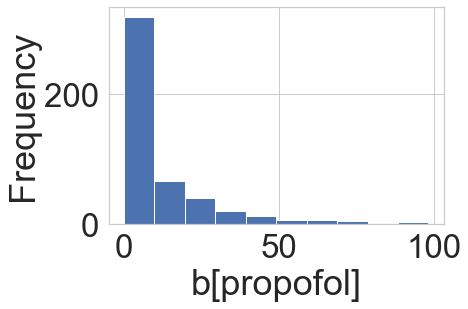

In [78]:
df_coarsen_1['b[propofol]'].plot(kind='hist')
plt.xlabel('b[propofol]')

Text(0.5, 0, 'Hx Sz')

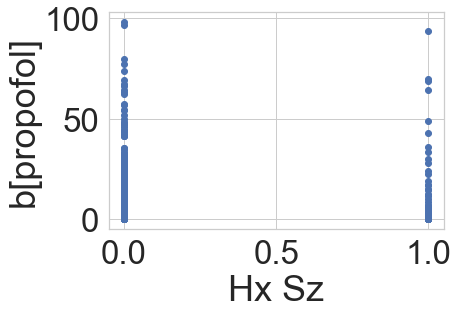

In [84]:
plt.scatter(y=df_coarsen_1['b[propofol]'],x=df_coarsen_1['Hx Sz'])
plt.ylabel('b[propofol]')
plt.xlabel('Hx Sz')